# Evaluating the Model

### Install Requirements

In [13]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn
!pip install openpyxl

### Import Required Libraries

In [14]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
import fiftyone as fo
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms
from IPython.display import display


### Specify Model

There are several output folders from training multiple models.  

In [15]:
# set this to today's date
today = "2024-03-15"

# modify output folder suffix if needed
suffix = "kfold_train"

# name of output folder
output_folder_name = today + "_" + suffix

data_path = '/home/jovyan/work/data/2024-03-14_leaves'
output_folder = f'/home/jovyan/work/mask_rcnn/{output_folder_name}'

k=5

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [16]:
import numpy as np
from PIL import Image, ImageOps
import fiftyone as fo

# Assuming leaf_predictor is defined elsewhere and dataset is an iterable of samples
datasets = {}

for fold in range(0, 5):
    
    base_path = f"{output_folder}/fold_{fold}/"

    leaf_cfg = get_cfg()
    leaf_cfg.MODEL.DEVICE='cpu'
    leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
    leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

    leaf_predictor = DefaultPredictor(leaf_cfg)
    
    print(f'Loading fold {fold} into fiftyone dataset...')
    
    datasets[f'fold_{fold}'] = fo.Dataset.from_dir(
        data_path=f"{data_path}",
        labels_path=f"{output_folder}/test_{fold}.json",
        dataset_type=fo.types.COCODetectionDataset, 
        name=f"{today}_fold_{fold}",
        label_types="segmentations",
        overwrite=True
    )
    
    print(f'Performing inference for fold {fold}...')

    with fo.ProgressBar() as pb:
        for sample in pb(datasets[f'fold_{fold}']):
            image = Image.open(sample.filepath)
            image = ImageOps.exif_transpose(image)  # Ensure correct orientation
            image_arr = np.array(image)
            h, w, _ = image_arr.shape

            outputs = leaf_predictor(image_arr)

            # Initialize counters for each class
            red_square_pixels, leaf_pixels, qr_pixels = 0, 0, 0
            detections = []

            for i, (mask, box, label, score) in enumerate(zip(outputs["instances"].pred_masks.numpy(),
                                                              outputs["instances"].pred_boxes.tensor.numpy(),
                                                              outputs["instances"].pred_classes.numpy(),
                                                              outputs["instances"].scores.numpy())):
                x1, y1, x2, y2 = box
                rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]  # Relative bounding box

                bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
                mask_pixel_count = np.count_nonzero(bbox_mask)

                class_label = ['leaf', 'qr', 'red-square'][label]

                # Update pixel counts based on class
                if class_label == 'leaf':
                    leaf_pixels += mask_pixel_count
                elif class_label == 'red-square':
                    red_square_pixels += mask_pixel_count  # Assuming you want to sum red square pixels
                elif class_label == 'qr':
                    qr_pixels += mask_pixel_count

                detections.append(fo.Detection(
                    label=class_label,
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                ))

            # print(f'image: {sample.filepath}, red_square_pixels: {red_square_pixels}, leaf_pixels: {leaf_pixels}, qr_pixels: {qr_pixels}')

            # Calculate leaf area
            leaf_area = None
            if red_square_pixels:
                # Red square is 2cm x 2cm, or 4 cm2
                leaf_area = (4 * leaf_pixels) / red_square_pixels
            elif qr_pixels:
                 # QR is 1.2cm x 1.2cm, or 1.44 cm2
                leaf_area = (1.44 * leaf_pixels) / qr_pixels

            # if leaf_area is not None:
            #     print(f'leaf area: {leaf_area:.2f} cm2')

            # Update sample with detections and calculated area
            sample["predictions"] = fo.Detections(detections=detections)
            sample["height"] = h
            sample["width"] = w
            sample["area"] = leaf_area
            sample.save()


[05/30 16:41:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/fold_0/model_final.pth ...
Loading fold 0 into fiftyone dataset...
 100% |███████████████████| 36/36 [9.4s elapsed, 0s remaining, 3.6 samples/s]      
Performing inference for fold 0...
 100% |███████████████████| 36/36 [58.6s elapsed, 0s remaining, 0.6 samples/s]    
[05/30 16:42:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/fold_1/model_final.pth ...
Loading fold 1 into fiftyone dataset...
 100% |███████████████████| 35/35 [8.3s elapsed, 0s remaining, 4.1 samples/s]      
Performing inference for fold 1...
 100% |███████████████████| 35/35 [1.0m elapsed, 0s remaining, 0.6 samples/s]     
[05/30 16:44:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-15_kfold_train/fold_2/model_final.pth ...
Loading fold

IMG_5858
Precision:  1.0
Recall:  0.5
Num matches: 1


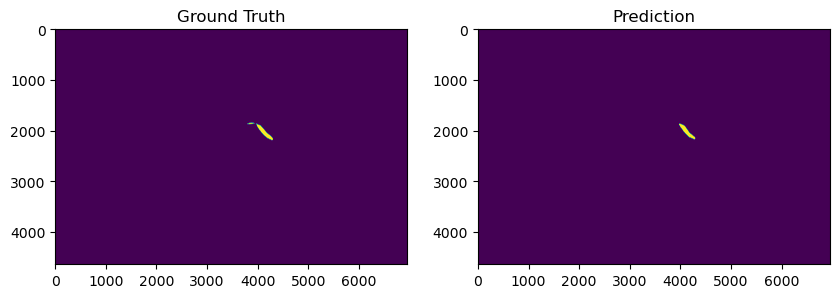

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_pixels(bbox, height, width):
    x1, y1, w, h = bbox
    return [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]

def calculate_mask(detections, height, width):
    mask = np.zeros((height, width), dtype=bool)
    for d in detections:
        if d.label == 'leaf':
            bbox = d.bounding_box
            x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
            mask[round(y1):round(y2), round(x1):round(x2)] |= d.mask
    return mask

def calculate_iou_and_dice(gt_mask, pred_mask):
    # if np.count_nonzero(gt_mask) == 0 and np.count_nonzero(pred_mask) == 0:
    #     # Perfect agreement in the absence of objects
    #     return 1, 1
    
    intersect = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    # Normal IoU and Dice calculation when there are objects
    iou = intersect_pixels / union_pixels if union_pixels else None
    dice = (2 * intersect_pixels) / (np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask)) if np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask) else None
    
    return iou, dice

def visualize_masks(gt_mask, pred_mask):
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')
    axarr[0].imshow(gt_mask)
    axarr[1].imshow(pred_mask)
    plt.show()
    

def calculate_precision_recall(ground_truths, predictions, iou_threshold=0.5):
    matches = []
    matched_gt_indices = set()  # To track which ground_truths are matched

    # Matching detections between predictions and ground_truths
    for pred in predictions:
        best_iou = 0
        best_match_index = None
        for index, gt in enumerate(ground_truths):
            print(gt['bounding_box'], pred['bounding_box'])
            iou, dice = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])
            if iou > best_iou:
                best_iou = iou
                best_match_index = index
        if best_iou >= iou_threshold:
            matches.append((pred, ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(predictions) - true_positives
    false_negatives = len(ground_truths) - len(matched_gt_indices)  # Ground truths not matched

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches)

def calculate_pixel_level_precision_recall(gt_mask, pred_mask):
    TP = np.sum(np.logical_and(pred_mask == 1, gt_mask == 1))
    FP = np.sum(np.logical_and(pred_mask == 1, gt_mask == 0))
    FN = np.sum(np.logical_and(pred_mask == 0, gt_mask == 1))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return precision, recall


def calculate_precision_recall_count(ground_truths, predictions, iou_threshold=0.5):
    # Filter detections to include only those with the label 'leaf'
    filtered_ground_truths = [gt for gt in ground_truths if gt['label'] == 'leaf']
    filtered_predictions = [pred for pred in predictions if pred['label'] == 'leaf']

    matches = []
    matched_gt_indices = set()  # Tracks which ground_truths are matched

    # Matching detections between filtered predictions and filtered ground_truths
    for pred_index, pred in enumerate(filtered_predictions):
        best_iou = 0
        best_match_index = None
        for gt_index, gt in enumerate(filtered_ground_truths):
            if gt_index in matched_gt_indices:
                continue  # Skip already matched ground truths
            # print(gt)
            iou, _ = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])  # Dice can be ignored if not needed
            if iou > best_iou:
                best_iou = iou
                best_match_index = gt_index
        
        if best_iou >= iou_threshold:
            matches.append((pred, filtered_ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(filtered_predictions) - true_positives
    false_negatives = len(filtered_ground_truths) - len(matched_gt_indices)
    


    # Keep the original print statements
    # print('True positives: ', true_positives)
    # print('False positives: ', false_positives)
    # print('False negatives: ', false_negatives)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches), true_positives, false_positives, false_negatives



dataset_1 = datasets['fold_0']
# print(dataset_1)
sample = dataset_1.first()
height, width = sample.height, sample.width
ground_truth_mask = calculate_mask(sample.ground_truth.detections, height, width)
prediction_mask = calculate_mask(sample.predictions.detections, height, width)
filename = sample.filepath.split('/')[-1].split('.')[0]
print(filename)
precision, recall, num_matches, tp, fp, fn = calculate_precision_recall_count(sample.ground_truth.detections, sample.predictions.detections)
print('Precision: ', precision)
print('Recall: ', recall)
print('Num matches:', num_matches)

visualize_masks(ground_truth_mask, prediction_mask)
    

In [18]:
import pandas as pd

# initialize dataframe from manual area file, and add column for ml_area
df = pd.read_excel('/home/jovyan/work/data/manual_area.xlsx')

columns_to_initialize = ['ml_area', 'ground_truth_pixels', 'prediction_pixels', 'iou', 'dice', 'count_precision', 'count_recall', 'num_matches', 'tp', 'fp', 'fn',  'mask_precision', 'mask_recall']

# Initialize columns to None and then convert to float
for column in columns_to_initialize:
    df[column] = None
    df[column] = df[column].astype(float)

df['fold'] = "fold"
    
missing_from_file = []

for fold_name, dataset in datasets.items():
    
    print('\n' + fold_name)
    print('---------------------------')
    
    fold_iou = []
    fold_dice = []

    for sample in dataset:

        filename = sample.filepath.split('/')[-1].split('.')[0]

        if not df.loc[df['picture'].str.startswith(filename)].empty:
            df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2)) 
        else:
            missing_from_file.append(filename)
        
        height, width = sample.height, sample.width
        ground_truth_mask = calculate_mask(sample.ground_truth.detections, height, width)
        prediction_mask = calculate_mask(sample.predictions.detections, height, width)
        precision, recall, matches, tp, fp, fn = calculate_precision_recall_count(sample.ground_truth.detections, sample.predictions.detections)

        print(filename)

        iou, dice = calculate_iou_and_dice(ground_truth_mask, prediction_mask)
        pixel_precision, pixel_recall = calculate_pixel_level_precision_recall(ground_truth_mask, prediction_mask)
        print(pixel_precision,  pixel_recall)
 
        
        # print(dice)
        row = df['picture'].str.startswith(filename)
        
        df.loc[row, 'ground_truth_pixels'] = np.count_nonzero(ground_truth_mask)
        df.loc[row, 'prediction_pixels'] = np.count_nonzero(prediction_mask)
        df.loc[row, 'iou'] = round(iou, 3) if iou is not None else None
        df.loc[row, 'dice'] = round(dice, 3) if dice is not None else None
        df.loc[row, 'count_precision'] = round(precision, 3)
        df.loc[row, 'count_recall'] = round(recall, 3)
        df.loc[row, 'num_matches'] = matches  
        df.loc[row, 'tp'] = tp  
        df.loc[row, 'fp'] = fp  
        df.loc[row, 'fn'] = fn
        df.loc[row, 'fold'] = fold_name
        df.loc[row, 'mask_precision'] = pixel_precision
        df.loc[row, 'mask_recall'] = pixel_recall
        
        fold_iou.append(iou)
        fold_dice.append(dice)

        # visualize_masks(ground_truth_mask, prediction_mask)
    
    fold_iou = np.array(fold_iou, dtype=float)
   

    print('Min IOU: ', np.nanmin(fold_iou))
    print('Max IOU: ', np.nanmax(fold_iou))
    print('Average IOU: ', np.nanmean(fold_iou))

    print('\n')
    fold_dice = np.array(fold_dice, dtype=float)
    print('Min Dice: ', np.nanmin(fold_dice))
    print('Max Dice: ', np.nanmax(fold_dice))
    print('Average Dice: ', np.nanmean(fold_dice))


df_area = df[df['ml_area'] >= 0.0]
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)
print(df)

# Calculate means for specific columns
mean_values = {
    'ground_truth_pixels': None,
    'prediction_pixels': None,
    'iou': np.nanmean(df['iou']),
    'dice': np.nanmean(df['dice']),
    'count_precision': df['count_precision'].mean(),
    'count_recall': df['count_recall'].mean(),
    'mask_precision': df['mask_precision'].mean(),
    'mask_recall': df['mask_recall'].mean(),
    'num_matches': None,
}

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_values, index=['average'])

# Append the new DataFrame with averages to the original DataFrame
df = pd.concat([df, mean_df])


# Specify the path and name of the CSV file you want to create
csv_file_path = f'{output_folder}/{output_folder_name}.csv'

# Export the DataFrame to CSV
df.to_csv(csv_file_path, index=False)



fold_0
---------------------------
IMG_5858
0.9341484716157206 0.8395868002135075
IMG_5869
0.8696177504393673 0.9394802420790317
IMG_5871
0.9144867968072019 0.9529128263731895
IMG_5879
0 0.0
IMG_5908
0.8632636742293142 0.6058108662696717
IMG_5918
0.8725987991582524 0.49928197423944504
IMG_5924
0.9453073591748665 0.9421211566617862
IMG_5951
0.9682871405678711 0.9347306913766449
IMG_5957
0.9463584120096171 0.8979038293018792
IMG_5958
0.9479073372748427 0.9353443336770941
IMG_5959
0.9623209782949058 0.9067661058009613
IMG_5962
0.9602929703843573 0.9511836383358482
IMG_5970
0.9393171527566575 0.9669185845782935
IMG_5973
0.9137261249595339 0.751664447403462
IMG_5976
0.9467953617167001 0.7578099190055582
IMG_5984
0.9578974070671475 0.904118187583315
IMG_5985
0.8856048955529925 0.8857964605314811
IMG_5990
0.9550027805351154 0.9412258763274216
IMG_5993
0.9271154845215903 0.7496787585252546
IMG_5997
0.9694944259123771 0.9484676159713692
IMG_5998
0.9544194203155617 0.9384689300675598
IMG_6000
0

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


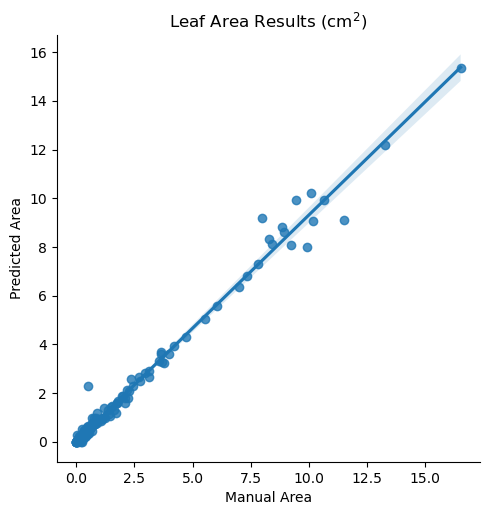

In [19]:
import seaborn as sns
plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
plt.set(xlabel='Manual Area', ylabel='Predicted Area')
plt.set(title="Leaf Area Results (cm$^{2}$)")
plt.savefig("leaf_area.png", dpi=300)


In [20]:
df_area.corr(numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice,count_precision,count_recall,num_matches,tp,fp,fn,mask_precision,mask_recall
area_cm2,1.000000,0.993802,0.959802,0.949654,0.320556,0.259220,0.138091,0.101896,0.732871,0.743293,0.109309,0.462299,0.225182,0.260910
ml_area,0.993802,1.000000,0.953539,0.948476,0.313470,0.251270,0.136031,0.125180,0.754797,0.762192,0.131579,0.432741,0.214052,0.273775
ground_truth_pixels,0.959802,0.953539,1.000000,0.995849,0.341459,0.274337,0.138339,0.143859,0.668021,0.671337,0.134823,0.321293,0.234096,0.279075
prediction_pixels,0.949654,0.948476,0.995849,1.000000,0.329410,0.260539,0.129454,0.162490,0.666070,0.664662,0.161262,0.290617,0.214230,0.291311
iou,0.320556,0.313470,0.341459,0.329410,1.000000,0.977284,0.666274,0.545118,0.519646,0.545470,-0.024943,-0.020832,0.830594,0.842474
dice,0.259220,0.251270,0.274337,0.260539,0.977284,1.000000,0.782893,0.548960,0.467740,0.495495,-0.046637,-0.023368,0.901329,0.826544
count_precision,0.138091,0.136031,0.138339,0.129454,0.666274,0.782893,1.000000,0.592299,0.359449,0.410440,-0.207499,0.165782,0.926381,0.796005
count_recall,0.101896,0.125180,0.143859,0.162490,0.545118,0.548960,0.592299,1.000000,0.499667,0.458540,0.349032,-0.417834,0.592714,0.824430
num_matches,0.732871,0.754797,0.668021,0.666070,0.519646,0.467740,0.359449,0.499667,1.000000,0.985948,0.310053,0.250430,0.460105,0.577993
tp,0.743293,0.762192,0.671337,0.664662,0.545470,0.495495,0.410440,0.458540,0.985948,1.000000,0.146879,0.307211,0.487706,0.569247


In [21]:
from scipy import stats

corr = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print(corr)
r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

PearsonRResult(statistic=0.9938020963089774, pvalue=6.044334905083657e-168)
r^2: 0.9876426066281181


In [ ]:
df_area.corr(method='pearson', numeric_only=True)

In [ ]:
df_area.corr(method='kendall', numeric_only=True)

In [ ]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")

In [ ]:
session.refresh()

In [ ]:
results = df_area[df_area['ml_area'] >= 0.0]
results
mask = results['dice'] < .2

# Step 2: Calculate the percentage of samples meeting the condition
percentage = (mask.sum() / len(results)) * 100

print(f"Percentage of samples with dice score > 90: {percentage}%")